In [5]:
import numpy as np
from gwbench import network
from gwbench import snr

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from scipy.optimize import minimize
import dill
from pycbc import conversions as conv


In [2]:
import matplotlib


font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)


In [3]:
def get_network_response(inj_params, network_spec = ['aLIGO_H','aLIGO_L','aLIGO_V'], approximant='IMRPhenomXAS', deriv_symbs_string = 'Mc eta DL tc phic iota ra dec psi', cond_num=1e25):
    
    # initialize the network with the desired detectors
    net = network.Network(network_spec)

    # choose the desired waveform 
    wf_model_name = 'lal_bbh'
    # pass the chosen waveform to the network for initialization
    net.set_wf_vars(wf_model_name=wf_model_name, wf_other_var_dic = {'approximant': approximant})

    # pick the desired frequency range
    f_min = 5.
    f_max = 512.
    d_f = 2**-4
    f = np.arange(f_min, f_max, d_f)

    # choose whether to take Earth's rotation into account
    use_rot = 0

    # pass all these variables to the network
    net.set_net_vars(
        f=f, inj_params=inj_params,
        deriv_symbs_string=deriv_symbs_string,
        use_rot=use_rot
        )
    
    # # compute the WF polarizations
    net.calc_wf_polarizations()
    # # compute the WF polarizations and their derivatives
    net.calc_wf_polarizations_derivs_num()

    # setup antenna patterns, location phase factors, and PSDs
    net.setup_ant_pat_lpf_psds()

    # compute the detector responses
    net.calc_det_responses()
    # compute the detector responses and their derivatives
    net.calc_det_responses_derivs_num()

    # calculate the network and detector SNRs
    net.calc_snrs()

    

    # # calculate the network and detector Fisher matrices, condition numbers,
    # # covariance matrices, error estimates, and inversion errors
    net.calc_errors(cond_sup=cond_num)

    # # calculate the 90%-credible sky area (in deg)
    # net.calc_sky_area_90()

    return net


In [4]:
from astropy.cosmology import Planck18, z_at_value
import astropy.units as u
DL = Planck18.luminosity_distance(10).value
DL

105999.13587403279

For given 'true' and 'approximate' waveforms $h_{TR}$ and $h_{AP}$, the systematic error due to waveform inaccuracy on the parameter $\theta^i$ is given by:
$$ \Delta \theta^i = (\Gamma_{AP}^{-1})^{ij} \quad  \Sigma_{D=1}^{N_{det}}  (\partial_j (h_{AP})_D | (h_{TR})_D - (h_{AP})_D)$$


We will assume that IMRPhenomXAS is $h_{TR}$ (net1) and IMRPhenomD is $h_{AP}$ (net2).


# GW150914

https://arxiv.org/pdf/1606.01210.pdf

In [127]:
name = 'GW150914'

# Detector frame
Mc = 71.3 #M_sol
m1 = 38.7 #M_sol
m2 = 32.5 #M_sol
DL = 440 #Mpc
q = m2/m1

chi_eff = -0.04
chi_p = 0.32
a1 = 0.26
a2 = 0.32

# Mc = conv.mchirp_from_mass1_mass2(m1, m2)
eta = conv.eta_from_mass1_mass2(m1, m2)

print(eta)

0.24810432710516347


In [128]:
# set the injection parameters
inj_params = {
    'name': name,
    'Mc':    Mc,
    'eta':   eta,
    'chi1x': 0,
    'chi2x': 0,
    'chi1y': 0,
    'chi2y': 0,
    'chi1z': a1,
    'chi2z': a2,
    'DL':    DL,
    'tc':    0,
    'phic':  0,
    'iota':  np.pi/3,
    'ra':    np.pi/3,
    'dec':   np.pi/3,
    'psi':   np.pi/3,
    'gmst0': 0
    }


deriv_symbs_string = 'Mc eta DL chi1z chi2z iota ra dec psi'
param_list = deriv_symbs_string.split()

# network_spec = ['aLIGO_H','aLIGO_L','aLIGO_V']
network_spec = ['CE2-40-CBO_C', 'CE2-20-CBO_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
# network_spec = ['CE2-40-CBO_C']

net1 = get_network_response(inj_params=inj_params, network_spec=network_spec, deriv_symbs_string=deriv_symbs_string, \
                            approximant='IMRPhenomXAS', cond_num=1e25)

net2 = get_network_response(inj_params=inj_params, network_spec=network_spec, deriv_symbs_string=deriv_symbs_string, \
                            approximant='IMRPhenomD', cond_num=1e25)

net1.save_network(f'gwbench_networks/net_xas_{name}')
net2.save_network(f'gwbench_networks/net_d_{name}')



Polarizations calculated.
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Detector responses calculated.
Calculate numeric derivatives of detector responses.
  CE2-40-CBO_C
  CE2-20-CBO_S
  ET_ET1
  ET_ET2
  ET_ET3
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  CE2-40-CBO_C
  CE2-20-CBO_S
  ET_ET1
  ET_ET2
  ET_ET3
Errors calculated.
Polarizations calculated.
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Detector responses calculated.
Calculate numeric derivatives of detector responses.
  CE2-40-CBO_C
  CE2-20-CBO_S
  ET_ET1
  ET_ET2
  ET_ET3
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov mat

# GW190521

In [137]:
# https://arxiv.org/ftp/arxiv/papers/2009/2009.01075.pdf

name = 'GW190521'

# source frame
m1 = 85 #M_sol
m2 = 66 #M_sol
DL = 5300 #Mpc
q = m2/m1

chi_eff = 0.08
chi_p = 0.68
a1 = 0.69
a2 = 0.73

z = z_at_value(Planck18.luminosity_distance, DL * u.Mpc)

Mc = conv.mchirp_from_mass1_mass2(m1, m2) * (1+z)
eta = conv.eta_from_mass1_mass2(m1, m2)

print(Mc)
print(eta)
print(z)

118.31185987676761
0.2460418402701636
0.817380878297575


In [138]:
# set the injection parameters
inj_params = {
    'name': name,
    'Mc':    Mc,
    'eta':   eta,
    'chi1x': 0,
    'chi2x': 0,
    'chi1y': 0,
    'chi2y': 0,
    'chi1z': a1,
    'chi2z': a2,
    'DL':    DL,
    'tc':    0,
    'phic':  0,
    'iota':  np.pi/3,
    'ra':    np.pi/3,
    'dec':   np.pi/3,
    'psi':   np.pi/3,
    'gmst0': 0
    }


deriv_symbs_string = 'Mc eta DL chi1z chi2z iota ra dec psi'
param_list = deriv_symbs_string.split()

# network_spec = ['aLIGO_H','aLIGO_L','aLIGO_V']
network_spec = ['CE2-40-CBO_C', 'CE2-20-CBO_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
# network_spec = ['CE2-40-CBO_C']

net1 = get_network_response(inj_params=inj_params, network_spec=network_spec, deriv_symbs_string=deriv_symbs_string, \
                            approximant='IMRPhenomXAS', cond_num=1e25)

net2 = get_network_response(inj_params=inj_params, network_spec=network_spec, deriv_symbs_string=deriv_symbs_string, \
                            approximant='IMRPhenomD', cond_num=1e25)

net1.save_network(f'gwbench_networks/net_xas_{name}')
net2.save_network(f'gwbench_networks/net_d_{name}')



Polarizations calculated.
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Detector responses calculated.
Calculate numeric derivatives of detector responses.
  CE2-40-CBO_C
  CE2-20-CBO_S
  ET_ET1
  ET_ET2
  ET_ET3
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  CE2-40-CBO_C
  CE2-20-CBO_S
  ET_ET1
  ET_ET2
  ET_ET3
Errors calculated.
Polarizations calculated.
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Detector responses calculated.
Calculate numeric derivatives of detector responses.
  CE2-40-CBO_C
  CE2-20-CBO_S
  ET_ET1
  ET_ET2
  ET_ET3
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov mat

# Load gwbench networks

In [139]:
# name='GW150914'
name='GW190521'

with open(f'gwbench_networks/net_xas_{name}', "rb") as fi:
    net1 = dill.load(fi)

with open(f'gwbench_networks/net_d_{name}', "rb") as fi:
    net2 = dill.load(fi)

In [140]:
print(net1.inj_params["Mc"])
print(net2.snr)
print(list(net2.errs.values()))

118.31185987676761
447.55775643788616
[0.05703074431065895, 0.00041299523105598607, 30.836689473378236, 0.0034988454746169703, 0.006800493155515315, 0.004700265945018007, 0.0016854191779715143, 0.004300552239987169, 0.004602863922029738]


# Perform Cutler-Vallisneri with (IMRPhenomXAS, IMRPhenomD) and 3G network

In [141]:
# Calculate the Theoretical Bias in Parameters based on Cutler-Vallisneri formalism
def compute_wf_bias(net1, net2, param_list, lams=None, inj_params=None):
    inner_prod = np.zeros(len(param_list))
	
    cov_ap = net2.cov

    for d in range(len(net2.detectors)):
        del_h_ap_all = net2.detectors[d].del_hf
        del_params_j = list(del_h_ap_all.keys())
	

        h_tr = net1.detectors[d].hf
        h_ap = net2.detectors[d].hf
        psd = net2.detectors[d].psd
        freq_range = net2.detectors[d].f
        df = freq_range[1] - freq_range[0]

        for j, parameter_j in enumerate(del_params_j):
            del_h_ap_j = del_h_ap_all[parameter_j]
            # Inner Product
            inner_prod[j] += snr.scalar_product_freq_array(del_h_ap_j, h_tr - h_ap, psd, freq_range, df)
    return np.dot(cov_ap, inner_prod)	

In [142]:
param_list = deriv_symbs_string.split()
errors_th = compute_wf_bias(net1, net2, param_list)
print(param_list)
print(errors_th)
print()

print(net2.errs)

print(errors_th[0]/net2.errs["Mc"])


['Mc', 'eta', 'DL', 'chi1z', 'chi2z', 'iota', 'ra', 'dec', 'psi']
[ 5.85148641e-01  1.84538988e-02  6.65184789e+03 -2.37372010e-01
  4.35812236e-01  3.27016948e-02 -1.28896063e-02  1.84880155e-01
 -2.09619412e-01]

{'Mc': 0.05703074431065895, 'eta': 0.00041299523105598607, 'DL': 30.836689473378236, 'chi1z': 0.0034988454746169703, 'chi2z': 0.006800493155515315, 'iota': 0.004700265945018007, 'ra': 0.0016854191779715143, 'dec': 0.004300552239987169, 'psi': 0.004602863922029738}
10.260231535675857


118.31185987676761
0.5851486412792894


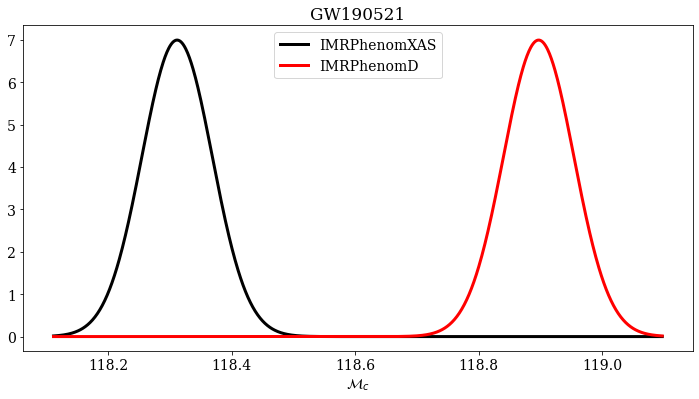

In [144]:
from scipy.stats import norm

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

mc_inj = net1.inj_params["Mc"]
stat_err = net2.errs["Mc"]
bias = errors_th[0]

print(mc_inj)
print(bias)

mc = np.linspace(mc_inj-0.2, mc_inj+bias+0.2, 1000)

plt.plot(mc, norm.pdf(mc, mc_inj, stat_err), lw=3, color='k', label="IMRPhenomXAS")
# plt.plot(mc, norm.pdf(mc, mc_inj+0.103, stat_err),lw=3, color='orange', label="$\lambda \\approx 0.1$")
plt.plot(mc, norm.pdf(mc, mc_inj+bias, stat_err),lw=3, color='r', label="IMRPhenomD")

# plt.axvline(x=mc_inj, ymin=0.05, color='k', ls='--')
# plt.axvline(x=mc_inj+0.103,  ymin=0.05, color='orange', ls='--')
# plt.axvline(x=mc_inj+bias,  ymin=0.05, color='r', ls='--')

# plt.semilogy()
plt.xlabel("$\mathcal{M}_{c}$")
plt.title(net1.inj_params["name"])
plt.legend()
plt.show()

# Plot the Bias across parameters

In [147]:
net2.inj_params["name"]

'GW190521'

In [150]:
def plot_bias(param_list, errors_th, figsize=(12,25)):
    f, ax= plt.subplots(len(param_list), 1,  figsize=figsize) 
    ax = list(ax)
    for i, param in enumerate((param_list)):
        mu = net2.inj_params[param]
        sigma = net2.errs[param]

        x = np.linspace(mu-3*errors_th[i], mu+3*errors_th[i], 10000)

        stat_est = stats.norm.pdf(x, mu, sigma)
        stat_est = stat_est/np.max(stat_est)

        theory_est = stats.norm.pdf(x, mu+errors_th[i], sigma)
        theory_est = theory_est/ np.max(theory_est)

        ax[i].plot(x, stat_est, label=f"Approximate (IMRPhenomD) Est")
        ax[i].plot(x, theory_est, label=f"True (IMRPhenomXAS) Est")
        
        if i==0:
            ax[i].legend(bbox_to_anchor=(0, 1), loc='upper left', fontsize=14)

        
        ax[i].set_xlim(mu-2*errors_th[i], mu+3*errors_th[i])
        ax[i].set_xlabel(param, fontsize=20)

    plt.suptitle(net2.inj_params["name"] + " Systematic Bias \n IMRPhenomXAS and IMRPhenomD", y=1.02, fontsize=20)
    plt.tight_layout()
    plt.show()

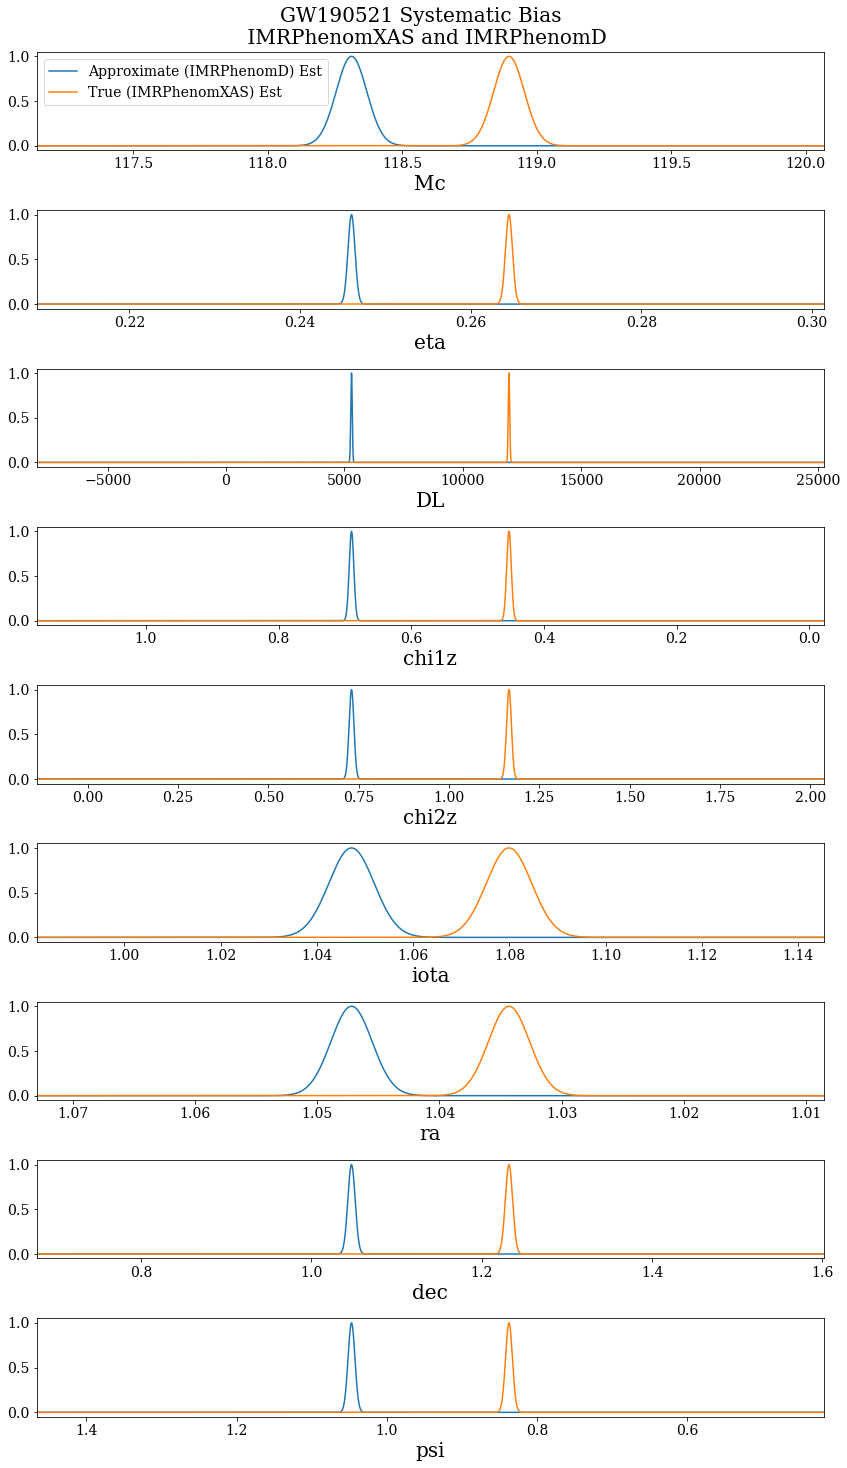

In [151]:
plot_bias(param_list[:], errors_th, figsize=(12, 20))


# Construct Hybrid Waveform

## Antenna Pattern Calculation

In [53]:
import antenna_pattern_np as gw_ap

In [54]:
def waveform_to_det_response(hp, hc, inj_params, detector):
    Mc = inj_params["Mc"]
    tc = inj_params["tc"]
    ra = inj_params["ra"]
    dec = inj_params["dec"]
    psi = inj_params["psi"]
    gmst0 = inj_params["gmst0"]
    use_rot = 0

    f = detector.f
    loc = detector.loc

    Fp, Fc, Flp = gw_ap.antenna_pattern_and_loc_phase_fac(f,Mc,tc,ra,dec,psi,gmst0,loc,use_rot)
    return Flp * (Fp * hp + Fc * hc)    

In [55]:
h1_response = waveform_to_det_response(net1.hfp, net1.hfc, inj_params, net1.detectors[0])
h2_response = waveform_to_det_response(net2.hfp, net2.hfc, inj_params, net2.detectors[0])

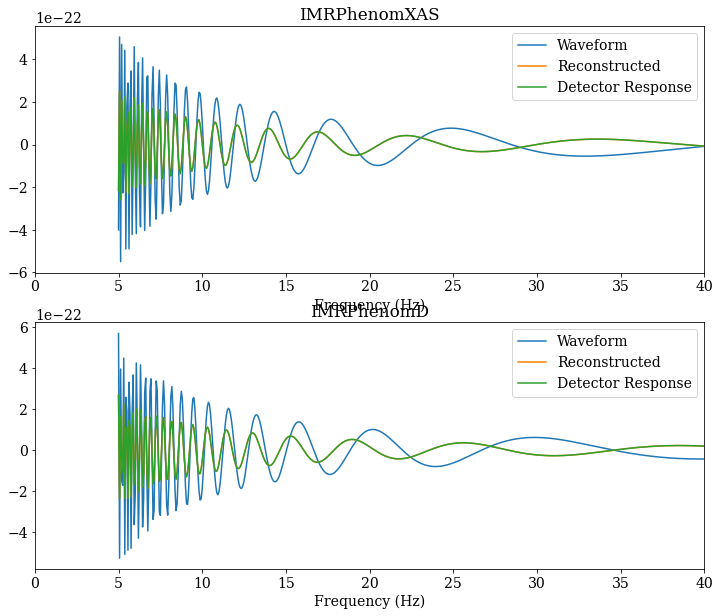

In [56]:
f, (ax)= plt.subplots(2, 1,  figsize=(12,10)) 

ax[0].plot(net1.f, np.real(net1.hfp), label="Waveform")
ax[0].plot(net1.f, np.real(h1_response), label="Reconstructed")
ax[0].plot(net1.detectors[0].f, np.real(net1.detectors[0].hf), label="Detector Response")
ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_title("IMRPhenomXAS")
ax[0].set_xlim(0, 40)
ax[0].legend()

ax[1].plot(net2.f, np.real(net2.hfp), label="Waveform")
ax[1].plot(net2.f, np.real(h2_response), label="Reconstructed")
ax[1].plot(net2.detectors[0].f, np.real(net2.detectors[0].hf), label="Detector Response")
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_title("IMRPhenomD")
ax[1].set_xlim(0, 40)
ax[1].legend()

plt.show()

## Hybrid Waveform Calculation

Let's express the two waveforms using following decompositions:
$$ h^{(1)}_{lm}(f) = A^{(1)}_{lm}(f) \exp[{i \phi^{(1)}_{lm}(f)}]$$
$$ h^{(2)}_{lm}(f) = A^{(2)}_{lm}(f) \exp[{i \phi^{(2)}_{lm}(f)}]$$

We want to minimize the initial time difference, which can be expressed as a frequency-dependent phase factor $ \exp[{i (\Delta\phi)}] = \exp[{i ( \phi_a + \phi_b f)}] $

Therefore, our task is to find a phase offset $\Delta \phi$ that minimizes the integrated phase difference 
$$ \int_{f_{min}}^{f_{max}}  \phi^{(1)}(f) -  (\phi^{(2)}(f)+ \Delta \phi) \;\; df $$
$$ = \int_{f_{min}}^{f_{max}}  \phi^{(1)}(f) -  \phi^{(2)}(f) - \phi_a - (\phi_b \cdot f) \;\; df $$

In [57]:
def phase_diff_integral(phis, args):
    phi_a, phi_b = phis[0], phis[1]

    phi1, phi2, f_min, f_max, freq_range = args[0], args[1], args[2], args[3], args[4]
    phase_diff = np.sum(phi1 - phi2)
    return  np.abs(phase_diff - (phi_a*(f_max - f_min)) - (phi_b * (((f_max**2) /2) - ((f_min**2) /2))))


In [58]:
def get_delta_phi(hp1, hc1, hp2, hc2, detector):
    f_min = 5.
    f_max = 1024.
    d_f = 2**-4
    f = np.arange(f_min, f_max, d_f)

    Mc = inj_params["Mc"]
    tc = inj_params["tc"]
    ra = inj_params["ra"]
    dec = inj_params["dec"]
    psi = inj_params["psi"]
    gmst0 = inj_params["gmst0"]
    use_rot = 0

    f = detector.f
    loc = detector.loc

    Fp, Fc, Flp = gw_ap.antenna_pattern_and_loc_phase_fac(f,Mc,tc,ra,dec,psi,gmst0,loc,use_rot)

    h1 = Flp*(Fp*hp1 + Fc*hc1)
    h2 = Flp*(Fp*hp2 + Fc*hc2)

    phi1 = np.unwrap(np.angle(h1))   
    phi2 = np.unwrap(np.angle(h2))

    initial_guess = [1.0, 0.]
    args = [phi1, phi2, f_min, f_max, f]
    result = minimize(phase_diff_integral, initial_guess, args=args, method='Nelder-Mead')
    # print(result)
    
    phi_a_opt, phi_b_opt = result.x[0], result.x[1]


    delta_phi = phi_a_opt + (phi_b_opt*f)

    return delta_phi

In [59]:
# Hybrid Waveform
def get_hyb_wf(hp1, hc1, hp2, hc2, lam, opt_phi=False, detector=net1.detectors[0]):

    if (lam > 1. or lam < 0):
        raise Exception('lambda should be between 0.0 and 1.0. The value of lambda was: {}'.format(lam))

    # h_plus components
    a1_p = np.abs(hp1)
    phi1_p = np.unwrap(np.angle(hp1))  

    a2_p = np.abs(hp2)
    phi2_p = np.unwrap(np.angle(hp2))

    # h_cross components
    a1_c = np.abs(hc1)
    phi1_c = np.unwrap(np.angle(hc1))    

    a2_c = np.abs(hc2)
    phi2_c = np.unwrap(np.angle(hc2))

    if opt_phi:
        # Optimize for time shift of second waveform
        delta_phi = get_delta_phi(hp1, hc1, hp2, hc2, detector)
        phi2_p = (phi2_p + delta_phi) 
        phi2_c = (phi2_c + delta_phi) 

    # Construct Hybrid waveforms
    a_hyb_p = a1_p*(1-lam) + a2_p*(lam)
    phi_hyb_p = phi1_p*(1-lam) + phi2_p*(lam)

    a_hyb_c = a1_c*(1-lam) + a2_c*(lam)
    phi_hyb_c = phi1_c*(1-lam) + phi2_c*(lam)


    hp_hyb =  a_hyb_p * np.exp(1.j * phi_hyb_p)
    hc_hyb =  a_hyb_c * np.exp(1.j * phi_hyb_c)
    
    return hp_hyb, hc_hyb

In [60]:
hp_hyb, hc_hyb = get_hyb_wf(net1.hfp, net1.hfc, net2.hfp, net2.hfc, lam=0.5)
print(np.abs(np.sum(hp_hyb - net2.hfp)))
print(np.abs(np.sum(hc_hyb - net2.hfc)))

2.9221755094059436e-20
1.7047237963723113e-20


In [61]:
from pycbc.types import FrequencySeries
delta_f = net1.f[1] - net1.f[0]
psd = FrequencySeries(net1.detectors[1].psd, delta_f=delta_f) # calculate mismatch using any one detector PSD

hp1_pyc = FrequencySeries(net1.hfp, delta_f=delta_f)
hp2_pyc = FrequencySeries(net2.hfp, delta_f=delta_f)

hp1_norm = np.sum((hp1_pyc * np.conjugate(hp1_pyc)/psd).data)


lams = np.linspace(0, 1, 10)
inner_prods = np.zeros(10)

for l, lam in enumerate(lams):
    hp_hyb, hc_hyb = get_hyb_wf(net1.hfp, net1.hfc, net2.hfp, net2.hfc, lam)
    hp_hyb_pyc = FrequencySeries(hp_hyb, delta_f=delta_f)
    
    hyb_norm = np.sum((hp_hyb_pyc * np.conjugate(hp_hyb_pyc)/psd).data)

    inner_prods[l] = np.abs(np.sum((hp1_pyc * np.conjugate(hp_hyb_pyc)/psd).data))
    inner_prods[l] = inner_prods[l]/ np.abs(np.sqrt(hp1_norm*hyb_norm))

print(inner_prods)

[1.         0.97878195 0.91849986 0.82909194 0.72613473 0.62875053
 0.55498186 0.51365147 0.49838705 0.493099  ]


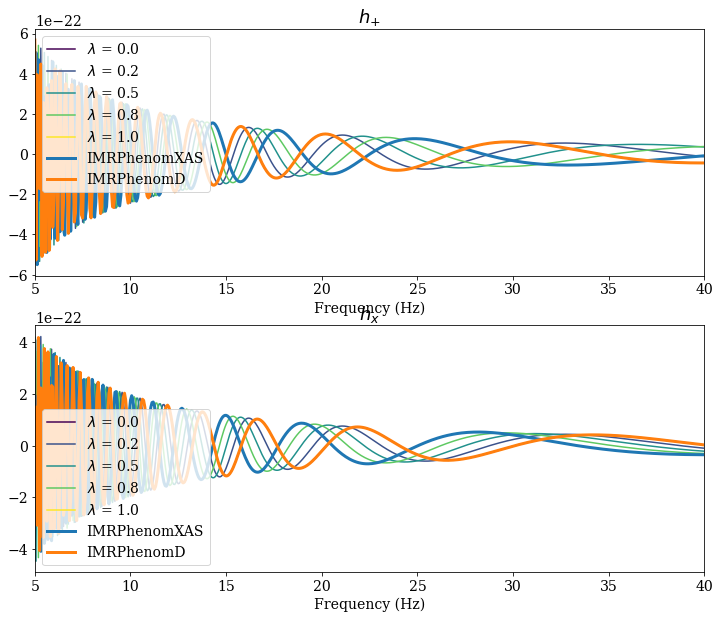

In [62]:
lams = np.linspace(0., 1., 5)
colors = plt.cm.viridis(lams)

f, (ax)= plt.subplots(2, 1,  figsize=(12,10)) 

for i, lam in enumerate(lams):
    # hp_hyb, hc_hyb = get_hyb_wf(net1.hfp, net1.hfc, net2.hfp, net2.hfc, lam)
    hp_hyb, hc_hyb = get_hyb_wf(net2.hfp, net2.hfc, net1.hfp, net1.hfc, lam)
    ax[0].plot(net2.f, np.real(hp_hyb), c=colors[i], label=f"$\lambda$ = {lam:.1f}")
    ax[1].plot(net2.f, np.real(hc_hyb), c=colors[i], label=f"$\lambda$ = {lam:.1f}")

ax[0].plot(net1.f, np.real(net1.hfp), lw=3, label="IMRPhenomXAS")
ax[0].plot(net2.f, np.real(net2.hfp), lw=3, label="IMRPhenomD")

ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_title("$h_{+}$", fontsize=18)

ax[1].plot(net1.f, np.real(net1.hfc), lw=3, label="IMRPhenomXAS")
ax[1].plot(net2.f, np.real(net2.hfc), lw=3, label="IMRPhenomD")

ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_title("$h_{x}$", fontsize=18)

ax[0].set_xlim(5, 40)
ax[0].legend()

ax[1].set_xlim(5, 40)
ax[1].legend()

plt.tight_layout
plt.show()

## Cutler-Vallisneri for Hybrid Waveforms

In [93]:
# Calculate the Theoretical Bias in Parameters based on Cutler-Valisneri formalism
# Interpolate the 'True' waveform for ease of calculation

lams = np.linspace(0., 0.002, 10)
errors_th_lam = np.zeros((len(lams), len(param_list)))

for l, lam in enumerate(lams):
    inner_prod = np.zeros(len(param_list))
    cov_ap = np.linalg.inv(lam*net1.fisher + (1-lam)*net2.fisher)

    for d in range(len(network_spec)):
        # del_h_ap_all = net1.detectors[d].del_hf
        del_params_j = list(net1.detectors[d].del_hf.keys())

        hp_hyb, hc_hyb = get_hyb_wf(net1.hfp, net1.hfc, net2.hfp, net2.hfc, lam, opt_phi=False)

        h_tr = net1.detectors[d].hf
        h_ap = waveform_to_det_response(hp_hyb, hc_hyb, inj_params, net1.detectors[d])

        psd = net2.detectors[d].psd
        freq_range = net2.detectors[d].f
        df = freq_range[1] - freq_range[0]

        for j, parameter_j in enumerate(del_params_j):
            del_h_ap_j = (1-lam)*net1.detectors[d].del_hf[parameter_j]  + lam*net2.detectors[d].del_hf[parameter_j] 
            
            # Inner Product
            inner_prod[j] += snr.scalar_product_freq_array(del_h_ap_j, h_tr - h_ap, psd, freq_range, df)
        
    # Calculate the theoretical bias across parameters
    errors_th_lam[l,:] = np.dot(cov_ap, inner_prod)


In [94]:
# Print only Mc errors
print(errors_th_lam[:,0])
print(lams)

[-4.74654396e-13 -5.04782445e-03 -1.00554790e-02 -1.50232799e-02
 -1.99515399e-02 -2.48405684e-02 -2.96906717e-02 -3.45021529e-02
 -3.92753120e-02 -4.40104456e-02]
[0.         0.00022222 0.00044444 0.00066667 0.00088889 0.00111111
 0.00133333 0.00155556 0.00177778 0.002     ]


In [95]:
def plot_single_param_bias(error_th, param, lam=0., figsize=(12,25), xlim=None):
    f, ax= plt.subplots(1, 1,  figsize=figsize) 
    
    mu = net2.inj_params[param]
    sigma = net2.errs[param]

    x = np.linspace(mu-30, mu+30, 10000)

    stat_est = stats.norm.pdf(x, mu, sigma)
    # stat_est = stat_est/np.max(stat_est)

    theory_est = stats.norm.pdf(x, mu+error_th, sigma)
    # theory_est = theory_est/ np.max(theory_est)

    ax.plot(x, stat_est, label=f"Approximate (IMRPhenomD) Est")
    ax.plot(x, theory_est, label=f"Hybrid (lam={lam:.3f}) Est")
    
    ax.legend(bbox_to_anchor=(0, 1), loc='upper left', fontsize=16)

    if xlim is None:
        ax.set_xlim(mu-2*error_th, mu+3*error_th)
    else:
        ax.set_xlim(xlim)
        
    ax.set_xlabel(param, fontsize=20)

    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.title("Systematic Bias b/w IMRPhenomXAS and IMRPhenomD", y=1.02, fontsize=20)
    # plt.tight_layout()
    plt.show()

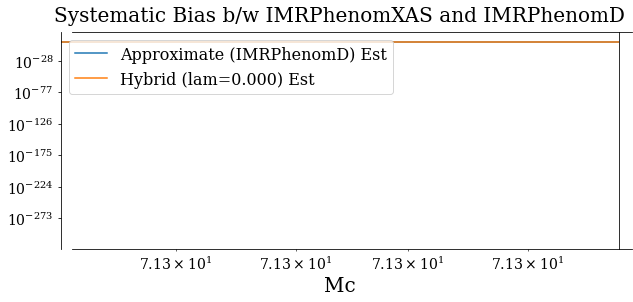

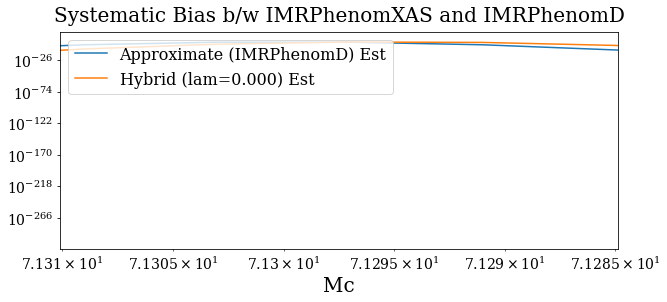

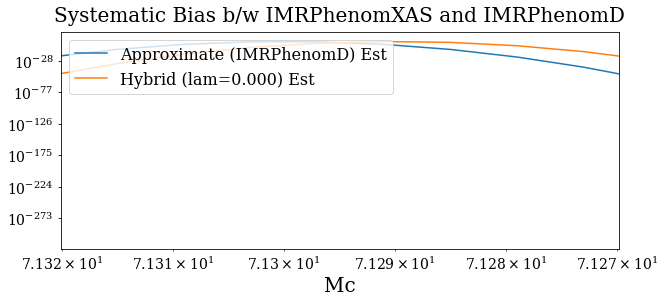

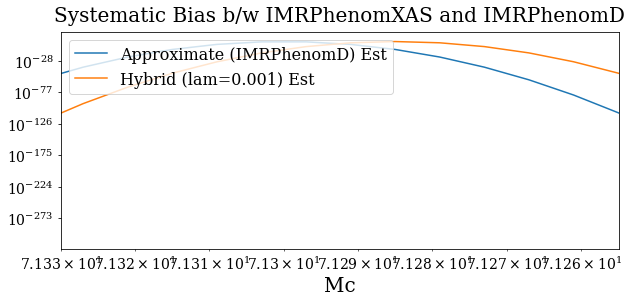

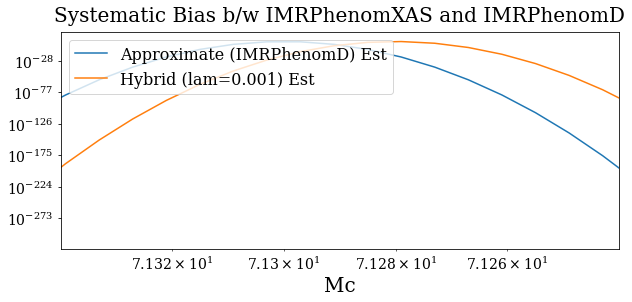

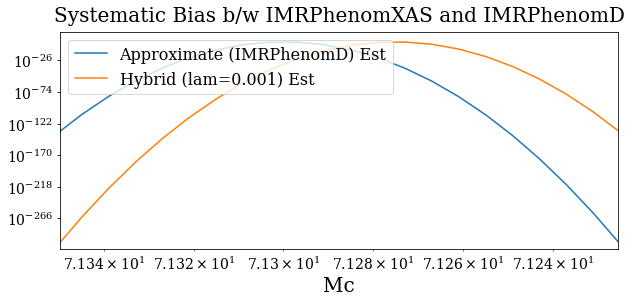

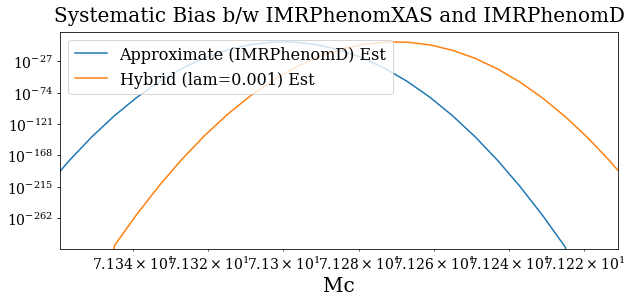

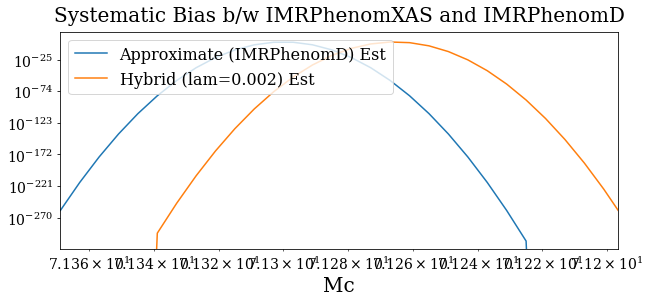

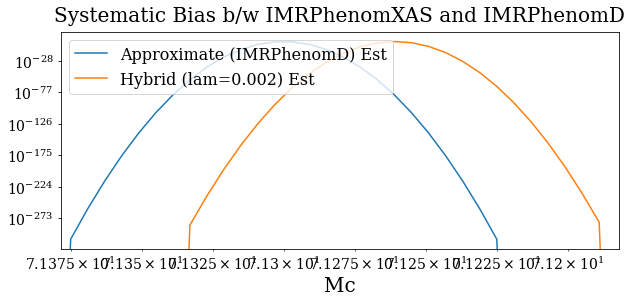

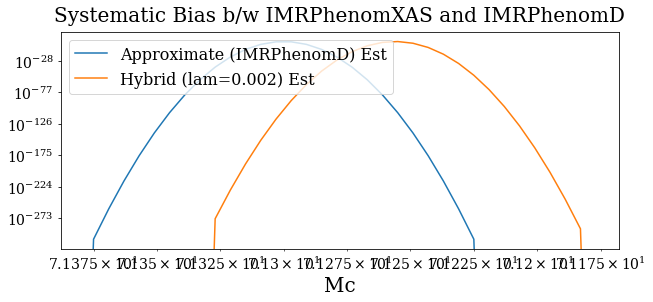

In [96]:
param = param_list
for i in range(len(lams[:])):
    plot_single_param_bias(errors_th_lam[i,0], lam=lams[i], param=param_list[0], figsize=(10, 4))

In [97]:
print(net2.errs["eta"])
errors_th_lam[:, 3]

7.549987544210043e-05


array([4.39285599e-13, 6.43073612e-03, 1.28216850e-02, 1.91731406e-02,
       2.54853937e-02, 3.17587321e-02, 3.79934406e-02, 4.41898010e-02,
       5.03480919e-02, 5.64685893e-02])

# Plot bias vs lambda

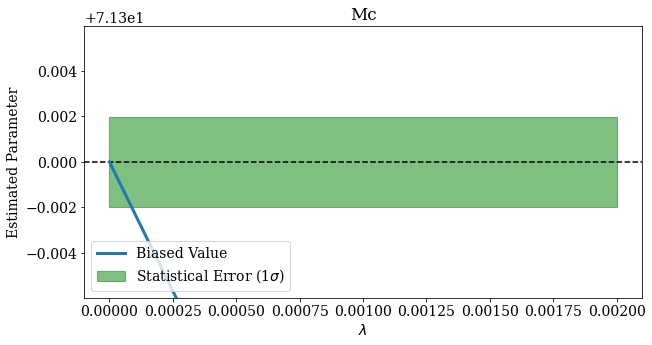

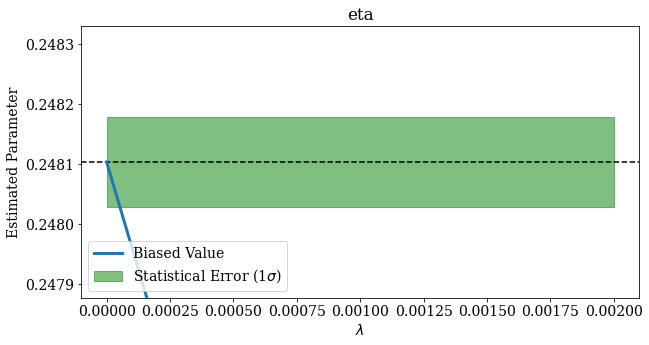

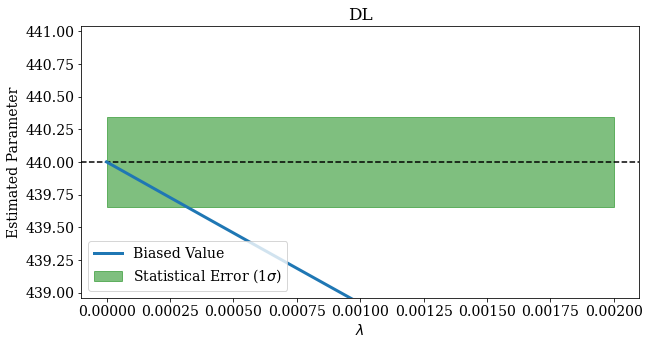

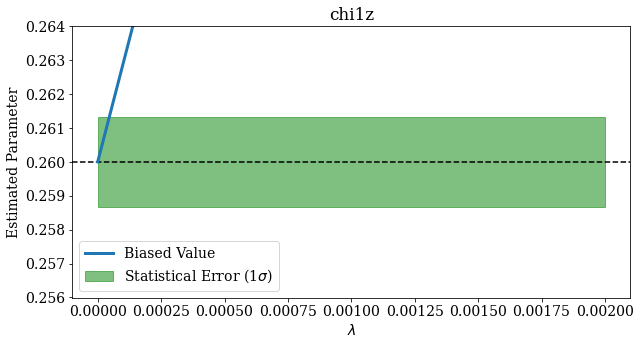

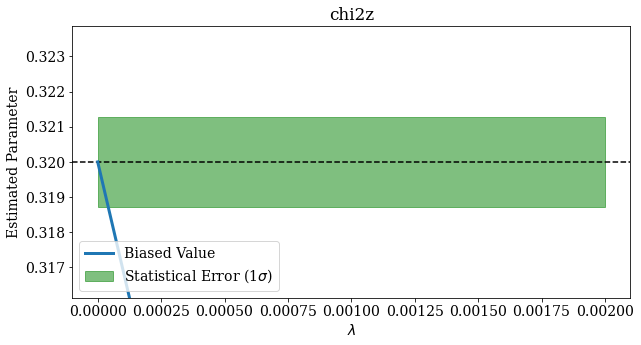

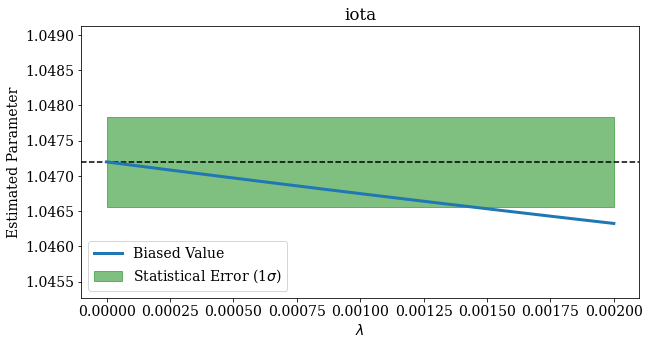

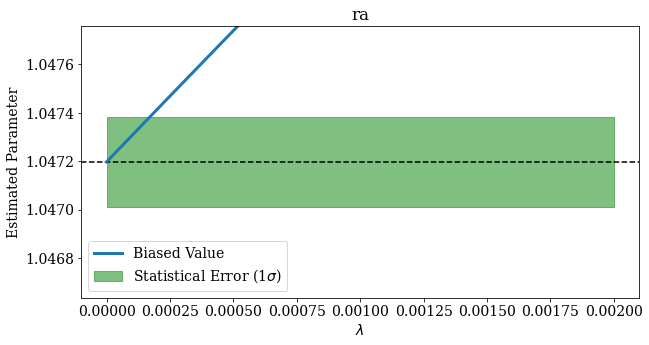

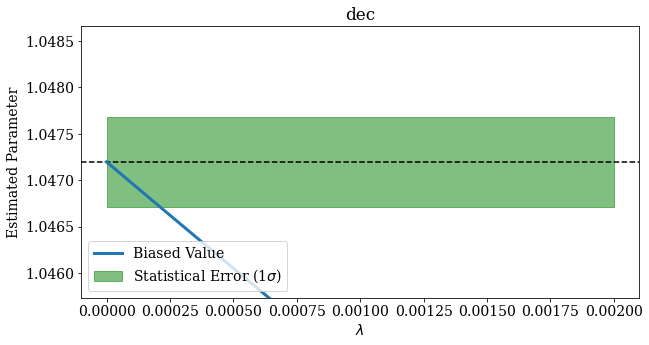

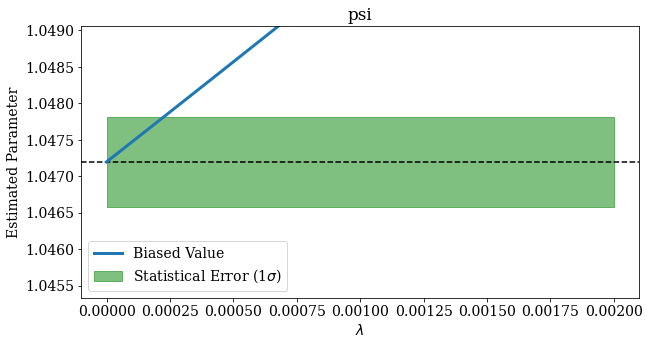

In [98]:
for p, param in enumerate(param_list):

    f, ax= plt.subplots(1, 1,  figsize=(10, 5)) 

    mu = net2.inj_params[param]
    sigma = net2.errs[param]

    plt.axhline(mu, color='k', linestyle='--' )
    plt.fill_between(lams, mu-sigma, mu+sigma, alpha=0.5, color='g', label="Statistical Error (1$\sigma$)")
    plt.plot(lams, mu+errors_th_lam[:, p], color='C0', lw=3, label='Biased Value')

    plt.legend(loc="lower left")

    plt.ylabel(f"Estimated Parameter")
    plt.xlabel("$\lambda$")
    plt.title(param)

    plt.ylim(mu-3*sigma, mu+3*sigma)

    plt.show()